# Jan 3rd, 2022 (Coreg ses play; fix 10_3)

**Motivation**: Co-register 3 sessions together, and fit CCF to only one of them. Fix subSLC10_ses-3 brain mask. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def _coronal(key, obj, t1w, figsize=(13.5, 16)):
    slices = range(21, 66, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[..., idx].T, cmap='bone')
        ax.imshow(x2plt[..., idx].T, alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Coronal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _sagittal(key, obj, t1w, figsize=(13.5, 12)):
    slices = range(2, 48, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[idx], cmap='bone')
        ax.imshow(x2plt[idx], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Sagittal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _axial(key, obj, t1w, figsize=(13.5, 13)):
    slices = range(2, 25, 2)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[:, idx, :], cmap='bone')
        ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Axial", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup

In [3]:
mice = Mice((64, 0, 100), load_parcel=True, full_load=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
# Get stuff from Parcel

cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)


# Random CMAP
rng = get_rng()
num = len(mice.parcel['regions-cortex'])
colors = (
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
)
colors = list(zip(*colors))
colors = [rgb2hex(c) for c in colors]
cmap = make_cmap(
    ramp_colors=colors,
    name='random_cmap',
    n_colors=num,
    show=False,
)

In [5]:
# HIDE CODE


obj_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])
objs, t1ws, masks = {}, {}, {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in obj_files
        if key in f
    )
    objs[key] = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    ).numpy()
    t1ws[key] = anat.load_ants().numpy()
    masks[key] = mice.mask3d[key].load_ants().numpy()

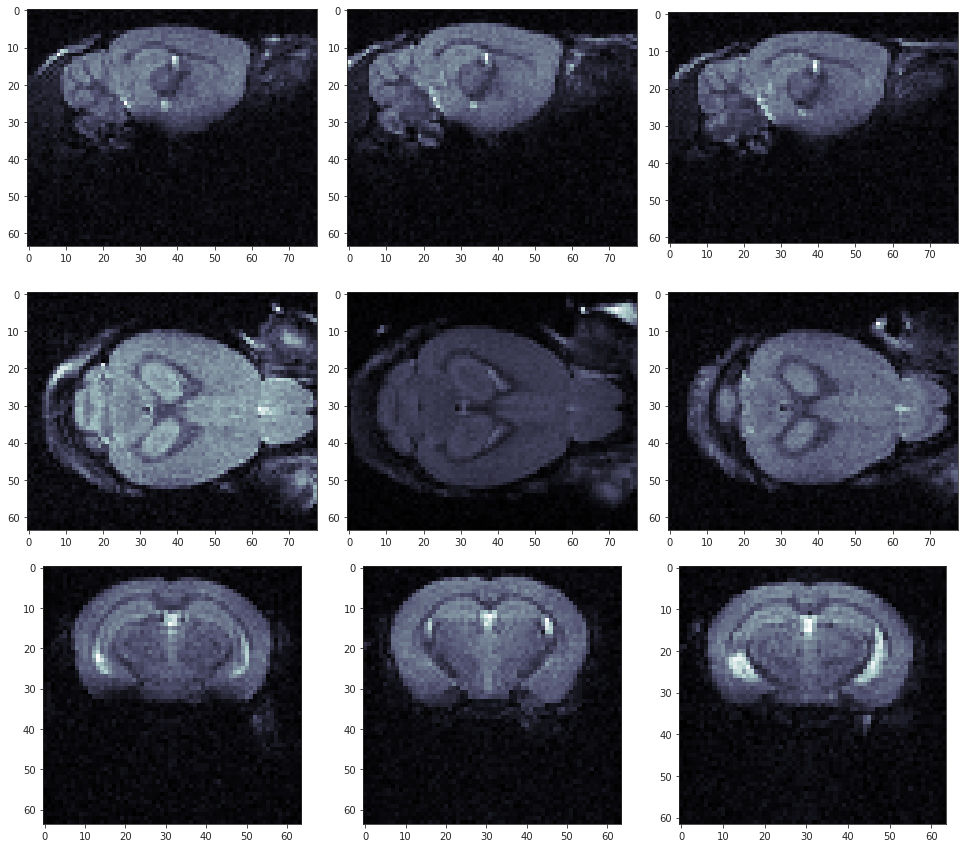

In [6]:
fig, axes = create_figure(3, 3, (13.5, 12))

keys = ['sub-SLC04_ses-1', 'sub-SLC04_ses-2', 'sub-SLC04_ses-3']
slices = [18, 10, 35]

for j, slice_idx in enumerate(slices):
    for i, ax in enumerate(axes[j].flat):
        x2plt = np.take(t1ws[keys[i]], slice_idx, axis=j)
        if j == 2:
            x2plt = x2plt.T
        ax.imshow(x2plt, cmap='bone')

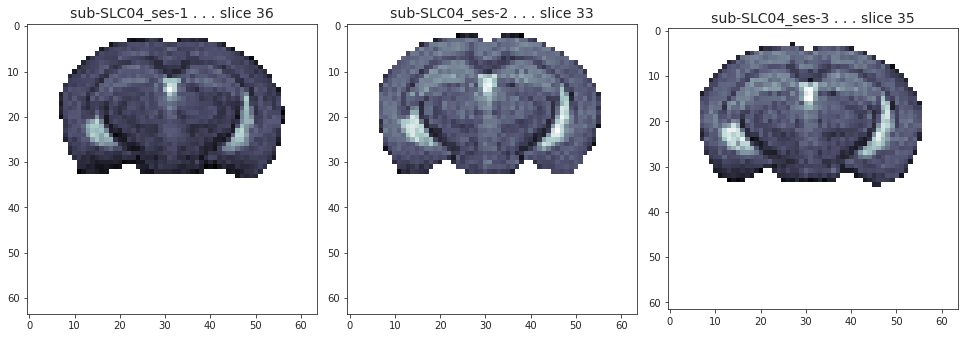

In [7]:
fig, axes = create_figure(1, 3, (13.5, 12))

slices = [36, 33, 35]
for i, ax in enumerate(axes.flat):
    m = np.take(masks[keys[i]], slices[i], axis=2)
    x2plt = np.take(t1ws[keys[i]], slices[i], axis=2)
    x2plt = np.ma.masked_where(~m.astype(bool), x2plt)
    x2plt = x2plt.T
    ax.imshow(x2plt, cmap='bone')
    ax.set_title(f"{keys[i]} . . . slice {slices[i]}", fontsize=14)

In [8]:
from register.register import reset_ants_img

x1 = mice.T1w[keys[0]].load_ants() * mice.mask3d[keys[0]].load_ants()
x2 = mice.T1w[keys[1]].load_ants() * mice.mask3d[keys[1]].load_ants()
x3 = mice.T1w[keys[2]].load_ants() * mice.mask3d[keys[2]].load_ants()

x1

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.colorbar.Colorbar object at 0x7eaea009c580>

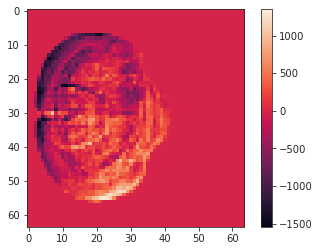

In [9]:
plt.imshow(x1.mean(-1) - x2.mean(-1))
plt.colorbar()

In [10]:
base_mi = ants.image_mutual_information(x1, x1)
mi = ants.image_mutual_information(x1, x2)
mi /= base_mi

mi

0.49903029649719893

In [11]:
txfile = ants.affine_initializer(
    fixed_image=x1,
    moving_image=x2,
    search_factor=5,
)
tx_aff = ants.read_transform(
    filename=txfile, dimension=3)
x2_aff = tx_aff.apply_to_image(
    image=x2,
    reference=x1,
    interpolation='linear',
)

mi = ants.image_mutual_information(
    image1=x2_aff, image2=x1)
mi /= base_mi
mi

0.7656929297053209

In [12]:
txfile = ants.affine_initializer(
    fixed_image=x1,
    moving_image=x3,
    search_factor=5,
)
tx_aff = ants.read_transform(
    filename=txfile, dimension=3)
x3_aff = tx_aff.apply_to_image(
    image=x3,
    reference=x1,
    interpolation='linear',
)

mi = ants.image_mutual_information(
    image1=x3_aff, image2=x1)
mi /= base_mi
mi

0.7709467245892451

In [13]:
tx = ants.registration(
    fixed=x1,
    moving=x2,
    type_of_transform='Rigid',
    random_seed=0,
    verbose=False,
)
x2_rig = tx.get('warpedmovout', None)

mi = ants.image_mutual_information(
    image1=x2_rig, image2=x1)
mi /= base_mi
mi

0.7791863290445383

In [14]:
tx = ants.registration(
    fixed=x1,
    moving=x3,
    type_of_transform='Rigid',
    random_seed=0,
    verbose=False,
)
x3_rig = tx.get('warpedmovout', None)

mi = ants.image_mutual_information(
    image1=x3_rig, image2=x1)
mi /= base_mi
mi

0.7653225734981266

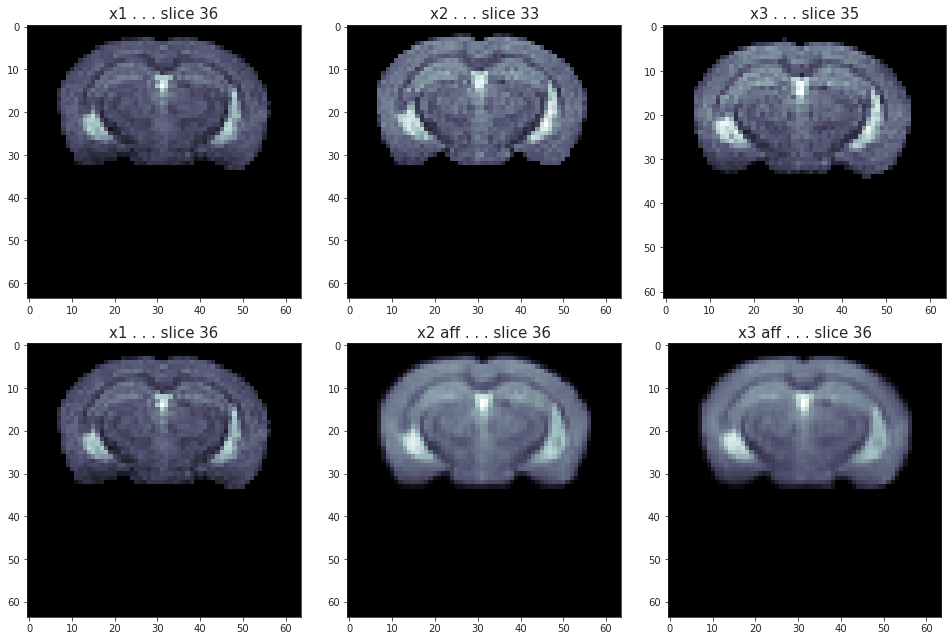

In [15]:
fig, axes = create_figure(2, 3, (13.5, 9))
slices = [36, 33, 35]
x2plt = x1[..., slices[0]].T
axes[0, 0].imshow(x2plt, cmap='bone')
x2plt = x2[..., slices[1]].T
axes[0, 1].imshow(x2plt, cmap='bone')
x2plt = x3[..., slices[2]].T
axes[0, 2].imshow(x2plt, cmap='bone')

axes[0, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[0, 1].set_title(f"x2 . . . slice {slices[1]}", fontsize=15)
axes[0, 2].set_title(f"x3 . . . slice {slices[2]}", fontsize=15)

x2plt = x1[..., slices[0]].T
axes[1, 0].imshow(x2plt, cmap='bone')
x2plt = x2_aff[..., slices[0]].T
axes[1, 1].imshow(x2plt, cmap='bone')
x2plt = x3_aff[..., slices[0]].T
axes[1, 2].imshow(x2plt, cmap='bone')

axes[1, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[1, 1].set_title(f"x2 aff . . . slice {slices[0]}", fontsize=15)
axes[1, 2].set_title(f"x3 aff . . . slice {slices[0]}", fontsize=15)

plt.show()

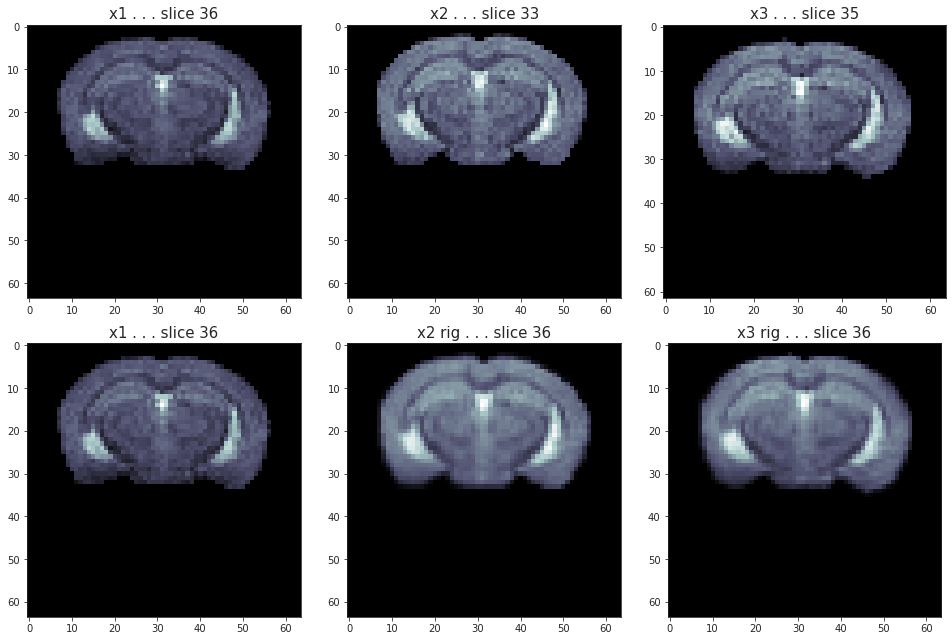

In [16]:
fig, axes = create_figure(2, 3, (13.5, 9))
slices = [36, 33, 35]
x2plt = x1[..., slices[0]].T
axes[0, 0].imshow(x2plt, cmap='bone')
x2plt = x2[..., slices[1]].T
axes[0, 1].imshow(x2plt, cmap='bone')
x2plt = x3[..., slices[2]].T
axes[0, 2].imshow(x2plt, cmap='bone')

axes[0, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[0, 1].set_title(f"x2 . . . slice {slices[1]}", fontsize=15)
axes[0, 2].set_title(f"x3 . . . slice {slices[2]}", fontsize=15)

x2plt = x1[..., slices[0]].T
axes[1, 0].imshow(x2plt, cmap='bone')
x2plt = x2_rig[..., slices[0]].T
axes[1, 1].imshow(x2plt, cmap='bone')
x2plt = x3_rig[..., slices[0]].T
axes[1, 2].imshow(x2plt, cmap='bone')

axes[1, 0].set_title(f"x1 . . . slice {slices[0]}", fontsize=15)
axes[1, 1].set_title(f"x2 rig . . . slice {slices[0]}", fontsize=15)
axes[1, 2].set_title(f"x3 rig . . . slice {slices[0]}", fontsize=15)


plt.show()

In [17]:
dlist = []
for sub in tqdm(mice.cfg.sub_ids):
    for i in mice.cfg.ses_ids:
        if sub == 10 and i == 3:
            continue
        key_1 = mice.get_key(sub, i)
        x1 = mice.T1w[key_1].load_ants() * mice.mask3d[key_1].load_ants()
        other_ses = [j for j in mice.cfg.ses_ids if j != i]
        for j in other_ses:
            if sub == 10 and j == 3:
                continue
            key_2 = mice.get_key(sub, j)
            x2 = mice.T1w[key_2].load_ants() * mice.mask3d[key_2].load_ants()

            tx = ants.registration(
                fixed=x1,
                moving=x2,
                type_of_transform='Rigid',
                verbose=False,
            )
            x_rig = tx.get('warpedmovout', None)

            base_mi = ants.image_mutual_information(
                image1=x1, image2=x1)
            mi_before = ants.image_mutual_information(
                image1=x1, image2=x2)
            mi = ants.image_mutual_information(
                image1=x1, image2=x_rig)

            perf = {
                'mi_before': mi_before / base_mi,
                'mi_after': mi / base_mi,
                'mi_ratio': mi / mi_before,
            }
            dlist.append({
                'sub': [sub] * len(perf),
                'ses_fx': [i] * len(perf),
                'ses_mv': [j] * len(perf),
                'label': perf.keys(),
                'score': perf.values(),
            })

df = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
_df = df.groupby(['sub', 'ses_fx', 'label']).mean().drop(columns=['ses_mv']).unstack()['score']
_df

label 
 mi_after 
 mi_before 
 mi_ratio 
 
 
 sub 
 ses_fx 
 
 
 
 
 
 
 
 1 
 1 
 0.768807 
 0.573357 
 1.341160 
 
 
 2 
 0.811355 
 0.659513 
 1.244131 
 
 
 3 
 0.804040 
 0.658573 
 1.229986 
 
 
 2 
 1 
 0.787552 
 0.453832 
 1.736138 
 
 
 2 
 0.791746 
 0.485775 
 1.639842 
 
 
 3 
 0.791346 
 0.490726 
 1.617564 
 
 
 3 
 1 
 0.773565 
 0.527210 
 1.467828 
 
 
 2 
 0.764465 
 0.522927 
 1.462657 
 
 
 3 
 0.771284 
 0.533657 
 1.445287 
 
 
 4 
 1 
 0.771269 
 0.549590 
 1.416262 
 
 
 2 
 0.783294 
 0.503027 
 1.557088 
 
 
 3 
 0.765282 
 0.536593 
 1.437913 
 
 
 5 
 1 
 0.782984 
 0.400583 
 1.967542 
 
 
 2 
 0.773694 
 0.461415 
 1.685072 
 
 
 3 
 0.776989 
 0.427155 
 1.861591 
 
 
 6 
 1 
 0.757774 
 0.486474 
 1.563212 
 
 
 2 
 0.799910 
 0.567247 
 1.410717 
 
 
 3 
 0.772927 
 0.505097 
 1.540583 
 
 
 7 
 1 
 0.727590 
 0.555988 
 1.311298 
 
 
 2 
 0.734313 
 0.505732 
 1.453660 
 
 
 3 
 0.763108 
 0.551398 
 1.393113 
 
 
 8 
 1 
 0.727694 
 0.541353 
 1.347053 
 
 
 2 
 0.735260 
 0.516836 
 1.431175 
 
 
 3 
 0.731082 
 0.493711 
 1.481657 
 
 
 9 
 1 
 0.750922 
 0.517145 
 1.452260 
 
 
 2 
 0.767863 
 0.504885 
 1.521160 
 
 
 3 
 0.765862 
 0.513106 
 1.493950 
 
 
 10 
 1 
 0.775573 
 0.347553 
 2.231524 
 
 
 2 
 0.764380 
 0.338470 
 2.258339

In [19]:
_df = df.groupby(['ses_fx', 'label']).mean().drop(columns=['ses_mv']).unstack()['score']
_df

label,mi_after,mi_before,mi_ratio
ses_fx,,,
1,0.761678,0.503085,1.549318
2,0.773062,0.515431,1.529965
3,0.771324,0.523335,1.500183


In [20]:
df.loc[
    (df['sub'] == 1) &
    (df['ses_fx'] == 2) &
    (df['label'] == 'mi_after')
]

,sub,ses_fx,ses_mv,label,score
7,1,2,1,mi_after,0.797080
10,1,2,3,mi_after,0.825629


In [21]:
df.loc[
    (df['sub'] == 1) &
    (df['label'] == 'mi_after')
]

,sub,ses_fx,ses_mv,label,score
1,1,1,2,mi_after,0.756743
4,1,1,3,mi_after,0.780872
7,1,2,1,mi_after,0.797080
10,1,2,3,mi_after,0.825629
13,1,3,1,mi_after,0.796633
16,1,3,2,mi_after,0.811447


In [26]:
ses_fx = 2
for sub in mice.cfg.sub_ids:
    key_fx = mice.get_key(sub, ses_fx)
    fx = mice.T1w[key_fx].load_ants() * mice.mask3d[key_fx].load_ants()
    base_mi = ants.image_mutual_information(
        image1=fx, image2=fx)
    for ses_mv in [j for j in mice.cfg.ses_ids if j != ses_fx]:
        key_mv = mice.get_key(sub, ses_mv)
        mv = mice.T1w[key_mv].load_ants() * mice.mask3d[key_mv].load_ants()

        tx = ants.registration(
            fixed=fx,
            moving=mv,
            type_of_transform='Rigid',
            verbose=False,
        )
        mv_rig = tx.get('warpedmovout', None)

        mi_before = ants.image_mutual_information(
            image1=fx, image2=mv)
        mi = ants.image_mutual_information(
            image1=fx, image2=mv_rig)
        mi /= base_mi
        
        print(f"sub = {sub}\tses_fx = {ses_fx}\tses_mv = {ses_mv}\tperf = {mi}")

sub = 1 ses_fx = 2      ses_mv = 1      perf = 0.7968861758794458

sub = 1 ses_fx = 2      ses_mv = 3      perf = 0.8255932420034123

sub = 2 ses_fx = 2      ses_mv = 1      perf = 0.7795538439141119

sub = 2 ses_fx = 2      ses_mv = 3      perf = 0.803898836761191

sub = 3 ses_fx = 2      ses_mv = 1      perf = 0.751920384634467

sub = 3 ses_fx = 2      ses_mv = 3      perf = 0.7760705737762849

sub = 4 ses_fx = 2      ses_mv = 1      perf = 0.7702971429831857

sub = 4 ses_fx = 2      ses_mv = 3      perf = 0.795165308422845

sub = 5 ses_fx = 2      ses_mv = 1      perf = 0.7705989455364318

sub = 5 ses_fx = 2      ses_mv = 3      perf = 0.7772377799498361

sub = 6 ses_fx = 2      ses_mv = 1      perf = 0.7923611845426427

sub = 6 ses_fx = 2      ses_mv = 3      perf = 0.8076923245985482

sub = 7 ses_fx = 2      ses_mv = 1      perf = 0.7155985871349507

sub = 7 ses_fx = 2      ses_mv = 3      perf = 0.7575810546426561

sub = 8 ses_fx = 2      ses_mv = 1      perf = 0.7105009838007238

sub = 8 ses_fx = 2      ses_mv = 3      perf = 0.7596275164763409

sub = 9 ses_fx = 2      ses_mv = 1      perf = 0.7486106231978301

sub = 9 ses_fx = 2      ses_mv = 3      perf = 0.7868172836481419

sub = 10        ses_fx = 2      ses_mv = 1      perf = 0.7637285956246027

sub = 10        ses_fx = 2      ses_mv = 3      perf = 0.5737392717217331

In [25]:
mv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [ ]:
pbar = tqdm(
    self.mice.T1w.items(),
    total=len(self.mice.T1w),
    dynamic_ncols=True,
    leave=self.verbose,
    position=0,
)
_s = []
for key, anat in pbar:
    pbar.set_description(f"registering anat {key}")
    if anat.nii_file is None:
        continue
    indiv = anat.load_ants()
    indiv *= self.mice.mask3d[key].load_ants()
    indiv = self._prepare(indiv)
    tx, tx_aff = self.load_tx(key)
    if tx:
        affined = tx_aff.apply_to_image(
            image=indiv,
            reference=self.nissl,
            interpolation='linear',
        )
        _ = self._apply_tx_obj2lps(
            name=key,
            moving=affined,
            moving_orig=indiv,
            tx_aff=tx_aff,
            tx=tx,
            use_mm=True,
            save_results=save_results,
        )
    else:
        results = self.fit_register(
            name=key,
            moving=indiv,
            fixed=self.nissl,
            save_results=save_results,
            **kwargs,
        )
        if results:
            _s.append(results['perf'])
if self.verbose and _s:
    msg = 'overal scores:\t'
    msg += f"{np.mean(_s):.3f} ± {np.std(_s):.3f}\n\n"
    print(msg)
return


## Fix subSLC10_ses-3

In [83]:
key = mice.get_key(10, 3)
t = mice.T1w[key].load_ants().numpy()
m = mice.mask3d[key].load_ants().numpy().astype(bool)

m_roll = np.roll(m, -3, 0)
m_roll = np.roll(m_roll, 4, 1)
m_roll = np.roll(m_roll, -1, 2)

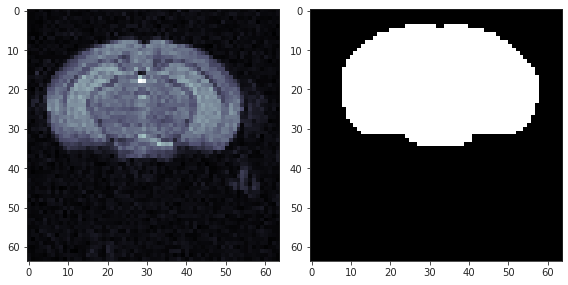

In [84]:
fig, axes = create_figure(1, 2, (8, 4))
axes[0].imshow(t[..., 30].T, cmap='bone')
axes[1].imshow(m[..., 30].T, cmap='bone')
plt.show()

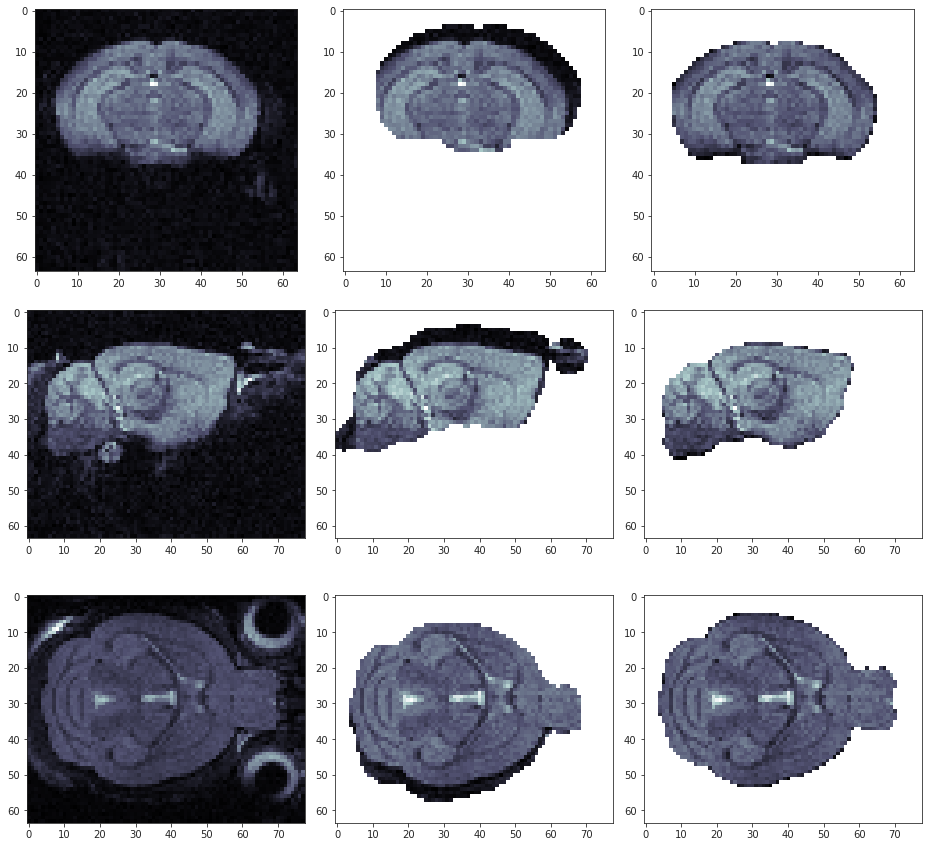

In [86]:
fig, axes = create_figure(3, 3, (13, 12))

i = 30
x2plt = np.ma.masked_where(~m[..., i], t[..., i])

axes[0, 0].imshow(t[..., i].T, cmap='bone')
axes[0, 1].imshow(x2plt.T, cmap='bone')


x2plt = np.ma.masked_where(~m_roll[..., i], t[..., i])
axes[0, 2].imshow(x2plt.T, cmap='bone')

j = 40
x2plt = np.ma.masked_where(~m[j], t[j])
axes[1, 0].imshow(t[j], cmap='bone')
axes[1, 1].imshow(x2plt, cmap='bone')

x2plt = np.ma.masked_where(~m_roll[j], t[j])
axes[1, 2].imshow(x2plt, cmap='bone')

j = 20
x2plt = np.ma.masked_where(~m[:, j, :], t[:, j, :])
axes[2, 0].imshow(t[:, j, :], cmap='bone')
axes[2, 1].imshow(x2plt, cmap='bone')

x2plt = np.ma.masked_where(~m_roll[:, j, :], t[:, j, :])
axes[2, 2].imshow(x2plt, cmap='bone')

plt.show()

In [90]:
m = mice.mask3d[key].load_ants()
m

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [93]:
roll_img = reset_ants_img(
    img=m_roll,
    spacing=m.spacing,
    origin=m.origin,
    dtype='uint32',
    use_um=False,
)
roll_img

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

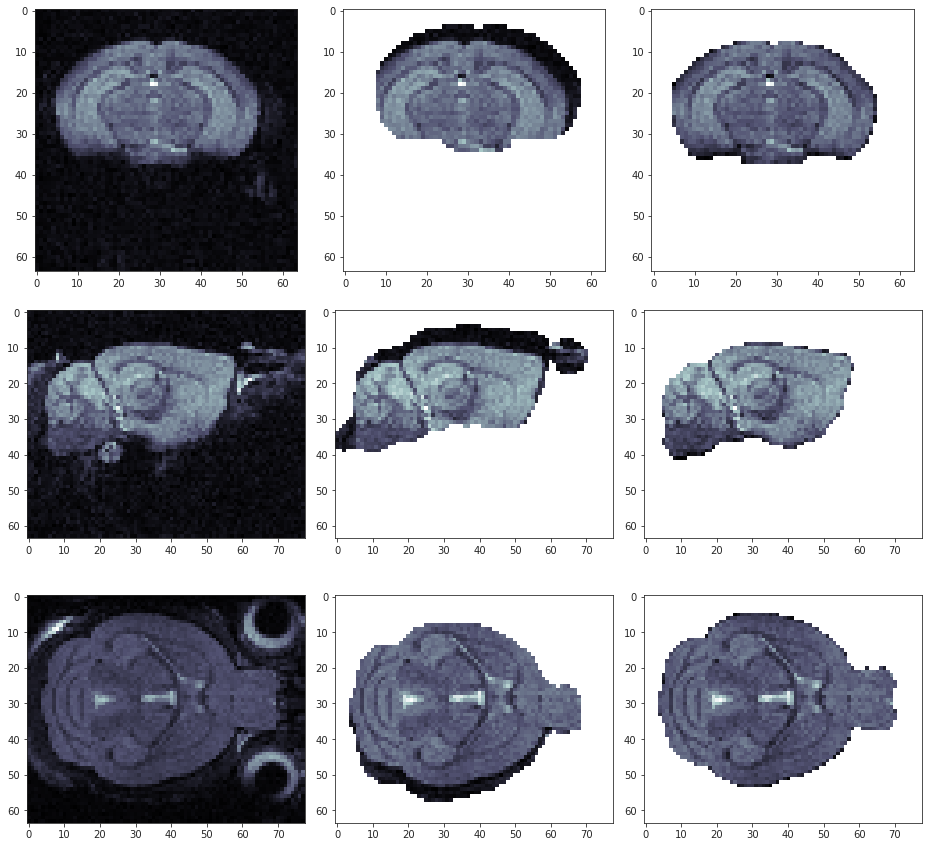

In [94]:
fig, axes = create_figure(3, 3, (13, 12))

i = 30
x2plt = np.ma.masked_where(~m.numpy().astype(bool)[..., i], t[..., i])

axes[0, 0].imshow(t[..., i].T, cmap='bone')
axes[0, 1].imshow(x2plt.T, cmap='bone')


x2plt = np.ma.masked_where(~roll_img.numpy().astype(bool)[..., i], t[..., i])
axes[0, 2].imshow(x2plt.T, cmap='bone')

j = 40
x2plt = np.ma.masked_where(~m.numpy().astype(bool)[j], t[j])
axes[1, 0].imshow(t[j], cmap='bone')
axes[1, 1].imshow(x2plt, cmap='bone')

x2plt = np.ma.masked_where(~roll_img.numpy().astype(bool)[j], t[j])
axes[1, 2].imshow(x2plt, cmap='bone')

j = 20
x2plt = np.ma.masked_where(~m.numpy().astype(bool)[:, j, :], t[:, j, :])
axes[2, 0].imshow(t[:, j, :], cmap='bone')
axes[2, 1].imshow(x2plt, cmap='bone')

x2plt = np.ma.masked_where(~roll_img.numpy().astype(bool)[:, j, :], t[:, j, :])
axes[2, 2].imshow(x2plt, cmap='bone')

plt.show()

In [96]:
vars(mice.mask3d[key])

{
    'cfg': <model.configuration.Config object at 0x7fb500489610>,
    '_patterns': ['sub-SLC10_ses-3', 'space-individual', 'mask_bold'],
    'key': 'sub-SLC10_ses-3',
    'mode': 'mask_bold',
    'space': 'individual',
    'npy_dir': '/mnt/storage/hadi/Ca-fMRI/npy',
    'nii_file': 'sub-SLC10_ses-3_space-individual_desc-mask_bold.nii.gz',
    'npy_file': None,
    'dtype': <class 'bool'>,
    '_npy': None,
    'shape': None
}

In [97]:
mice.mask3d[key].nii_file

'sub-SLC10_ses-3_space-individual_desc-mask_bold.nii.gz'

In [100]:
ants.image_write(roll_img, pjoin(mice.cfg.raw_dir, mice.mask3d[key].nii_file))